In [1]:
import numpy as np
import random
import sys
# import skorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm
import pandas as pd
from ptsa.data.timeseries import TimeSeries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import LeaveOneGroupOut, cross_validate

#### PYTORCH CONFIGURATION SETTINGS ######
device = "cpu"
#FOR GPU: device = "mps" if torch.has_mps else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
class LogisticRegressionTorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.logistic = torch.nn.Sequential(
            torch.nn.Linear(input_dim, output_dim, bias=True),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        # logits = torch.sigmoid(self.linear(x))
        probs = self.logistic(x)
        return probs
    
def train_loop(dataloader, model, loss_fn, optimizer, print_nth_batch=4, l2=None):
    size = len(dataloader.dataset)
    print("yay training")
    for batch, (X, y) in enumerate(dataloader):
        # print(y)
        # Compute prediction and loss
        pred = torch.squeeze(model(X))
        # print(pred)
        # regularization, computing largest singular value
        loss = loss_fn(pred, y)
        # if l2:
        #     loss = loss + l2*l2_reg(model)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % print_nth_batch == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    # we don't want to track gradients here because we're just doing
    # a forward pass to evaluate predictions
    with torch.no_grad():
        for X, y in dataloader:
            pred = torch.squeeze(model(X))
            test_loss += loss_fn(pred, y).item()
            # round predicted probs to get label prediction, compute n correct
            correct += (pred.round() == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
def test_auc_score(dataset, model):
    with torch.no_grad():
        X, y = dataset[:]
        pred = model(X)
        pred, y = pred.detach().numpy(), y.detach().numpy()
        score = roc_auc_score(y_true=y, y_score=pred)
        print("AUC:", score)
    return score

def l2_reg(model):
  """
  This function calculates the l2 norm of the all the tensors in the model
  Args:
    model: nn.module
      Neural network instance
  Returns:
    l2: float
      L2 norm of the all the tensors in the model
  """

  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)

  return l2

### Preconditioning Model (Raw signal)

In [2]:
class PrecondLogisticRegressionTorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim=3968):
        super().__init__()
        n_elec = 124
        self.condition = nn.Sequential(
            nn.Conv1d(in_channels=n_elec, out_channels=2*n_elec, kernel_size=1, padding=0, groups=n_elec),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2*n_elec, out_channels=4*n_elec, kernel_size=2, padding=0, groups=2*n_elec),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4*n_elec, out_channels=8*n_elec, kernel_size=4, padding=0, groups=4*n_elec),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=8*n_elec, out_channels=16*n_elec, kernel_size=8, padding=0, groups=8*n_elec),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16*n_elec, out_channels=8*n_elec, kernel_size=8, padding=0, groups=8*n_elec),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8),
            nn.Flatten()
        )
        self.logistic = nn.Sequential(
            nn.Linear(output_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_cond = self.condition(x)
        probs = self.logistic(x_cond)
        return probs

#### Training

In [7]:
ts = TimeSeries.from_hdf("/scratch/jrudoler/scalp_features/LTP106_eeg.h5")
# ts = ts.stack(row = ("event", "channel"), create_index=False).T
sessions = ts.session.values
y = torch.tensor(ts.recalled.values).float()
X = torch.tensor(ts.data).float()#[:, None, :]
del ts

In [57]:
# conv = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=2, stride=1, groups=1)
# avgpool = nn.AvgPool1d(kernel_size=2)
# out = conv(X[0:1])
# print(out.shape)
# pooled = avgpool(out)
# print(pooled.shape)

n_elec = 124
condition = nn.Sequential(
    nn.Conv1d(in_channels=n_elec, out_channels=2*n_elec, kernel_size=1, padding=0, groups=n_elec),
    nn.ReLU(),
    nn.AvgPool1d(kernel_size=2),
    nn.Conv1d(in_channels=2*n_elec, out_channels=4*n_elec, kernel_size=2, padding=0, groups=2*n_elec),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.Conv1d(in_channels=4*n_elec, out_channels=8*n_elec, kernel_size=4, padding=0, groups=4*n_elec),
    nn.ReLU(),
    nn.AvgPool1d(kernel_size=2),
    nn.Conv1d(in_channels=8*n_elec, out_channels=16*n_elec, kernel_size=8, padding=0, groups=8*n_elec),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
#     nn.Conv1d(in_channels=16*n_elec, out_channels=16*n_elec, kernel_size=8, padding=0, groups=16*n_elec),
#     nn.ReLU(),
    nn.AvgPool1d(kernel_size=2),
    nn.Conv1d(in_channels=16*n_elec, out_channels=8*n_elec, kernel_size=8, padding=0, groups=8*n_elec),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=8),
    nn.Flatten()
)

# condition = nn.Sequential(
#     nn.Conv1d(in_channels=1, out_channels=2, kernel_size=1, padding=0),
#     nn.AvgPool1d(kernel_size=2),
#     nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, padding=0),
#     nn.MaxPool1d(kernel_size=2),
#     nn.Conv1d(in_channels=4, out_channels=8, kernel_size=4, padding=0),
#     nn.AvgPool1d(kernel_size=2),
#     nn.Conv1d(in_channels=8, out_channels=16, kernel_size=8, padding=0),
#     nn.MaxPool1d(kernel_size=2),
#     nn.Conv1d(in_channels=16, out_channels=16, kernel_size=8, padding=0),
#     nn.AvgPool1d(kernel_size=2),
#     nn.Flatten()
# )

In [49]:
out = condition(X[0:5])
print(out.shape)
# pooled = avgpool(out)
# print(pooled.shape)

torch.Size([5, 992])


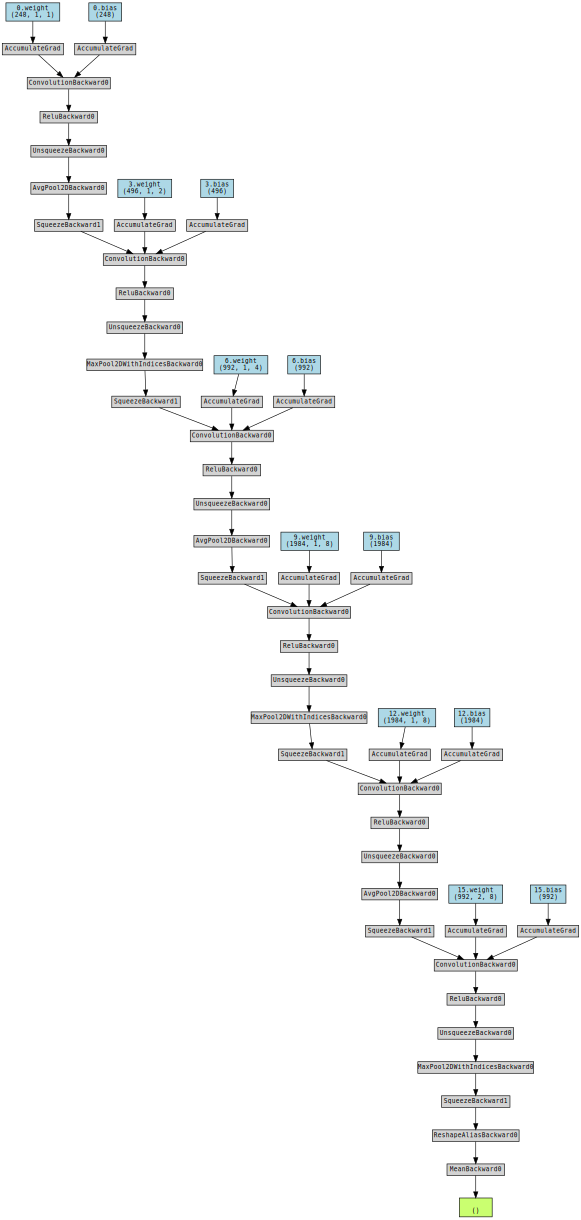

In [33]:
from torchviz import make_dot
make_dot(out.mean(), params=dict(condition.named_parameters()))

In [13]:
set_seed(56)
torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
torch_auc_list = []
sk_auc_list = []
logo = LeaveOneGroupOut()
for (i, (train_idx, test_idx)) in tqdm(list(enumerate(logo.split(X, y, groups=sessions)))):
    print(f"{'#'*30}\nSESSION {i}\n{'#'*30}")
    ## create model ##
    model = PrecondLogisticRegressionTorch(X.shape[-1])
    loss_fn = torch.nn.BCELoss()
    lr = 1e-4
    weight_decay = 1
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    ## data ##
    train_set = SimpleDataset(X[train_idx], y[train_idx])
    test_set = SimpleDataset(X[test_idx], y[test_idx])
    ## class balancing ##
    cls_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_set.y.detach().numpy()),
        y=train_set.y.detach().numpy(),
    )
    weights = cls_weights[train_set.y.detach().numpy().astype(int)]
    sampler = WeightedRandomSampler(
        weights, len(train_set.y.detach().numpy()), replacement=True
    )

    train_dataloader = DataLoader(train_set, batch_size=200, sampler=sampler)
    test_dataloader = DataLoader(test_set, batch_size=200, shuffle=True)

    ## training epochs ##
    EPOCHS = 10
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[2, 4, 6, 8])
    for t in range(EPOCHS):
        print(f"{'-'*30}\nEpoch {t+1}\n{'-'*30}")
        train_loop(train_dataloader, model, loss_fn, optimizer, print_nth_batch=2)
        test_loop(test_dataloader, model, loss_fn)
        out = test_auc_score(test_set, model)
#         if t in scheduler.milestones:
#             scheduler.step()
    torch_auc_list.append(out)

Random seed 56 has been set.


  0%|          | 0/24 [00:00<?, ?it/s]

##############################
SESSION 0
##############################
------------------------------
Epoch 1
------------------------------
yay training
loss: 0.693302  [    0/13248]
loss: 0.694271  [  400/13248]
loss: 0.693289  [  800/13248]
loss: 0.692862  [ 1200/13248]
loss: 0.693542  [ 1600/13248]
loss: 0.692980  [ 2000/13248]
loss: 0.692976  [ 2400/13248]
loss: 0.692850  [ 2800/13248]
loss: 0.692576  [ 3200/13248]
loss: 0.694361  [ 3600/13248]
loss: 0.693234  [ 4000/13248]
loss: 0.693732  [ 4400/13248]
loss: 0.693348  [ 4800/13248]
loss: 0.693344  [ 5200/13248]
loss: 0.693106  [ 5600/13248]
loss: 0.692824  [ 6000/13248]
loss: 0.692817  [ 6400/13248]
loss: 0.693106  [ 6800/13248]
loss: 0.693106  [ 7200/13248]
loss: 0.693568  [ 7600/13248]
loss: 0.693896  [ 8000/13248]
loss: 0.692635  [ 8400/13248]
loss: 0.693375  [ 8800/13248]
loss: 0.693213  [ 9200/13248]
loss: 0.693534  [ 9600/13248]
loss: 0.693961  [10000/13248]
loss: 0.693365  [10400/13248]
loss: 0.693263  [10800/13248]
loss:

KeyboardInterrupt: 

### Preconditioning Model (Features)

In [82]:
class PrecondFeatLogisticRegressionTorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim=3968, n_elec = 124):
        super().__init__()
        self.condition = nn.Sequential(
            nn.Conv1d(in_channels=n_elec, out_channels=2*n_elec, kernel_size=1, padding=0, groups=n_elec),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2*n_elec, out_channels=4*n_elec, kernel_size=2, padding=0, groups=2*n_elec),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )
        self.logistic = nn.Sequential(
            nn.Linear(output_dim, 1, bias=True),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_cond = self.condition(x)
        probs = self.logistic(x_cond)
        return probs

#### Training

In [85]:
ts = TimeSeries.from_hdf("/scratch/jrudoler/scalp_features/LTP093_feats.h5")
# ts = ts.unstack('features').transpose("event", "channel", "frequency")
# ts = ts.stack(row = ("event", "channel"), create_index=False).T
sessions = ts.session.values
y = torch.tensor(ts.recalled.values).float()
X = torch.tensor(ts.data).float()[:, None, :]

In [83]:
set_seed(56)
torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
torch_auc_list = []
sk_auc_list = []
logo = LeaveOneGroupOut()
for (i, (train_idx, test_idx)) in tqdm(list(enumerate(logo.split(X, y, groups=sessions)))):
    print(f"{'#'*30}\nSESSION {i}\n{'#'*30}")
    ## create model ##
    model = PrecondLogisticRegressionTorch(X.shape[-1])
    loss_fn = torch.nn.BCELoss()
    lr = .1
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0)
    ## data ##
    train_set = SimpleDataset(X[train_idx], y[train_idx])
    test_set = SimpleDataset(X[test_idx], y[test_idx])
    ## class balancing ##
    cls_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_set.y.detach().numpy()),
        y=train_set.y.detach().numpy(),
    )
    weights = cls_weights[train_set.y.detach().numpy().astype(int)]
    sampler = WeightedRandomSampler(
        weights, len(train_set.y.detach().numpy()), replacement=True
    )

    train_dataloader = DataLoader(train_set, batch_size=1000, sampler=sampler)

    ## training epochs ##
    EPOCHS = 10
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[2, 4, 6, 8])
    for t in range(EPOCHS):
        print(f"{'-'*30}\nEpoch {t+1}\n{'-'*30}")
        train_loop(train_dataloader, model, loss_fn, optimizer, print_nth_batch=2)
        out = test_auc_score(test_set, model)
#         if t in scheduler.milestones:
#             scheduler.step()
    torch_auc_list.append(out)

Random seed 56 has been set.


  0%|          | 0/23 [00:00<?, ?it/s]

##############################
SESSION 0
##############################
------------------------------
Epoch 1
------------------------------
yay training


RuntimeError: Given input size: (992x1x1). Calculated output size: (992x1x0). Output size is too small